# Image to Point Cloud

## Setup

In [2]:
# Setup Enviorment and Imports
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import cv2
import matplotlib.pyplot as plt
import open3d as o3d

import os
import random
from pathlib import Path
import glob

In [3]:
# Get Sample Images

imagePaths = glob.glob('images/roomSample*.png')
images = []
for path in imagePaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [4]:
# Import Depth Anything Model
processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf").to('cuda')

In [5]:
# Pre process images

imageSamples = []

for i in range(len(images)):
    input = processor(images=images[i], return_tensors='pt').to('cuda')

    #Inference
    with torch.no_grad():
        outputs = model(**input)
        depth = outputs.predicted_depth
    
    depth = depth.squeeze().cpu().numpy()
    imageSamples.append([images[i], depth])

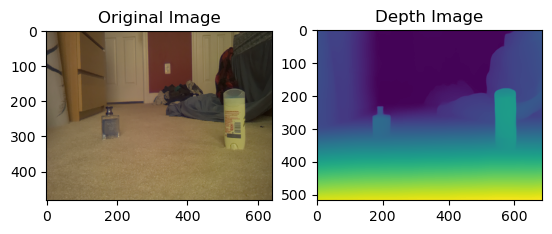

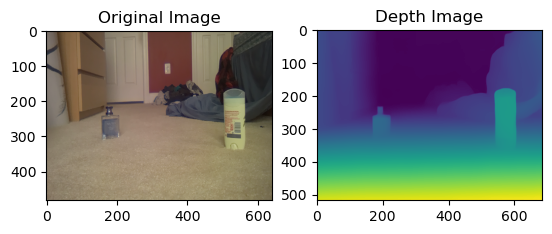

In [6]:
# Visualize Depth Image and Refrence Image

for i in range(len(images)):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(imageSamples[i][0])
    axs[0].set_title('Original Image')
    axs[1].imshow(imageSamples[i][1])
    axs[1].set_title('Depth Image')
    plt.show()

## Important Functions

In [7]:
def get_intrinsics(H,W, fov=73.0):
    """
    Returns Camera's Intrinsic Matrix
    FOV of IMX219-83 is 73 degrees (horizontal)
    """
    f = 0.5 * W / np.tan(0.5 * fov * np.pi / 180)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

In [8]:
def pixel_to_point(depth_image, camera_intrinsics=None):
    """
    Convert depth iamge to 3D points
    FOV of 73 degrees
    """

    height, width = depth_image.shape
    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width)
    
    # Create u, v meshgrid and precompute projection triangle ratios
    fx, fy = camera_intrinsics[0, 0], camera_intrinsics[1, 1]
    cx, cy = camera_intrinsics[0, 2], camera_intrinsics[1, 2]

    x = np.linspace(0, width -1, width)
    y = np.linspace(0, height -1, height)
    u, v = np.meshgrid(x, y)

    x_over_z = (u - cx) / (fx)
    y_over_z = (v - cy) / (fy)

    # 3-D Pythagoras re-arranged to solve for 2
    z = depth_image / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z
    y = y_over_z

    return x, y, z

In [9]:
def create_point_cloud(depth_image, color_image, camera_intrinsics=None, scale_ratio=10.0):

    height, width = depth_image.shape
    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width)

        color_image = cv2.resize(color_image, (width, height))


        #Make sure depth_image doesn't contain any zeros
        depth_image = np.maximum(depth_image, 1e-5)

        depth_image = scale_ratio /depth_image
        x, y, z = pixel_to_point(depth_image, camera_intrinsics)
        point_image = np.stack((x, y, z), axis=-1)

        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(point_image.reshape(-1, 3))
        cloud.colors = o3d.utility.Vector3dVector(color_image.reshape(-1, 3) / 255)

        return cloud

In [80]:
def remove_points_threshold(cloud, y_threshold, z_threshold):
    points = np.asarray(cloud.points)
    mask = points[:, 1] <= y_threshold
    filteredPoints = points[mask]
    mask = filteredPoints[:, 2] <= z_threshold
    filteredPoints = filteredPoints[mask]
    return o3d.utility.Vector3dVector(filteredPoints)

## Output Point Cloud

In [81]:
output_path = './pointclouds'

for i in range(len(images)):
    cloud = create_point_cloud(imageSamples[i][1], imageSamples[i][0])
    cloud.points = remove_points_threshold(cloud, 0.2, 3)
    o3d.io.write_point_cloud(os.path.join(output_path, f'roomPointCloud{i}.ply'), cloud)